In [115]:
#pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
df = pd.read_excel("updated_dataset_final.xlsx", parse_dates=['Tanggal']) #parse = untuk ngubah kolom Tanggal jadi datetime
df = df.sort_values('Tanggal')
df = df.reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  4020 non-null   datetime64[ns]
 1   TN       4020 non-null   float64       
 2   TX       4020 non-null   float64       
 3   TAVG     4020 non-null   float64       
 4   RH_AVG   4020 non-null   float64       
 5   RR       4020 non-null   float64       
 6   SS       4020 non-null   float64       
 7   FF_X     4020 non-null   int64         
 8   DDD_X    4020 non-null   int64         
 9   FF_AVG   4020 non-null   int64         
 10  DDD_CAR  4020 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 345.6 KB


In [4]:
df.tail(5)

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
4015,2025-12-03,26.8,32.8,28.6,76.0,0.0,4.2,7,300,1,0
4016,2025-12-04,26.2,30.4,26.7,83.0,25.9,3.6,3,290,1,0
4017,2025-12-05,23.8,32.6,27.4,77.0,47.5,0.5,3,280,1,0
4018,2025-12-06,25.4,32.0,28.1,75.0,0.0,7.2,3,280,1,135
4019,2025-12-07,26.2,31.6,29.1,74.0,0.0,4.4,4,310,2,225


In [ ]:
def add_safe_features(df):
    df = df.copy()

    # Extract month and day in Tanggal column
    df['month'] = df['Tanggal'].dt.month
    df['day']   = df['Tanggal'].dt.day

    # Create coordinat cos dan sin menggunakan rumus  
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['day_sin']   = np.sin(2*np.pi*df['day']/31)
    df['day_cos']   = np.cos(2*np.pi*df['day']/31)

    df['temp_range'] = df['Temperatur Maksimum'] - df['TN']

    # def month_to_season(m):
    #     if m in [12,1,2]: return 1
    #     elif m in [3,4,5]: return 2
    #     elif m in [6,7,8]: return 3
    #     else: return 4
    # df['season'] = df['month'].apply(month_to_season)

    return df

df = add_safe_features(df)


In [ ]:
train = df[df['Tanggal'] < '2024-01-01']
val   = df[(df['Tanggal'] >= '2024-01-01') & (df['Tanggal'] < '2025-01-01')]
test  = df[df['Tanggal'] >= '2025-01-01']


In [122]:
#df.info()

In [ ]:
def add_leakage_safe_lags(train, val, test):
    # Digabung, tapi rolling hanya dari bagian TRAIN
    full = pd.concat([train, val, test], axis=0)

    
    #Ambil data hujan sehari sebelum dan 
    full['Curah Hujan (mm)_lag1']  = full['Curah Hujan (mm)'].shift(1)
    full['Curah Hujan (mm)_lag2'] = full['Curah Hujan (mm)'].shift(2)
    full['Curah Hujan (mm)_lag3'] = full['Curah Hujan (mm)'].shift(3)
    full['Curah Hujan (mm)_lag7']  = full['Curah Hujan (mm)'].shift(7)
    full['Temperatur Rata-rata_lag1'] = full['Temperatur Rata-rata'].shift(1)

    full['Curah Hujan (mm)_diff1'] = full['Curah Hujan (mm)'] - full['Curah Hujan (mm)_lag1']
    full['RH_diff1'] = full['Kelembapan Rata-rata'] - full['Kelembapan Rata-rata'].shift(1)

    full['Curah Hujan (mm)_7d']  = full['Curah Hujan (mm)'].rolling(7).mean()
    full['Curah Hujan (mm)_14d'] = full['Curah Hujan (mm)'].rolling(14).mean()
    full['Curah Hujan (mm)_30d'] = full['Curah Hujan (mm)'].rolling(30).mean()

    full['Rain_7d_count'] = full['Curah Hujan (mm)'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # Setelah fitur selesai → split kembali
    train2 = full.loc[train.index]
    val2   = full.loc[val.index]
    test2  = full.loc[test.index]

    return train2, val2, test2

train, val, test = add_leakage_safe_lags(train, val, test)


In [124]:
train = train.dropna()
val   = val.dropna()
test  = test.dropna()


In [ ]:
features = [
    'TN','Temperatur Maksimum','Temperatur Rata-rata','Kelembapan Rata-rata','Lamanya Penyinaran Matahari','Kecepatan Angin Maksimum','Arah Angin Saat Kecepatan Maksimum','Kecepatan Angin Rata-rata','Arah Angin Terbanyak (°) ',
    'Curah Hujan (mm)_lag1','Curah Hujan (mm)_lag2','Curah Hujan (mm)_lag3', 'Curah Hujan (mm)_lag7','Temperatur Rata-rata_lag1','Curah Hujan (mm)_diff1','RH_diff1',
    'Curah Hujan (mm)_7d', 'Curah Hujan (mm)_14d','Curah Hujan (mm)_30d','Rain_7d_count',
    'month_sin','month_cos','day_sin','day_cos','temp_range'
]

X_train = train[features]
y_train = train['Curah Hujan (mm)']

X_val = val[features]
y_val = val['Curah Hujan (mm)']

X_test = test[features]
y_test = test['Curah Hujan (mm)']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

pred_rf = rf.predict(X_val_scaled)

# Perbaikan di sini: mean_squared_error
mse = mean_squared_error(y_val, pred_rf)      
rmse = np.sqrt(mse)

# Perbaikan di sini: mean_absolute_error
print("RF MAE:", mean_absolute_error(y_val, pred_rf)) 
print("RF RMSE:", rmse)

# Output Anda:
# RF MAE: 0.5942667449238894
# RF RMSE: 1.500483658715626

RF MAE: 0.6176434349123456
RF RMSE: 1.5097224545325554


In [ ]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squaredeCurah Hujan (mm)or'
)
xgb.fit(X_train_scaled, y_train)

pred_xgb = xgb.predict(X_val_scaled)

print("XGB MAE:", mean_absolute_error(y_val, pred_xgb))

#XGB MAE: 0.7026166778040924


XGB MAE: 0.6651907316780792


In [128]:
# reshape → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Perbaikan: parameter 'loss'
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

pred_lstm = model.predict(X_val_lstm)

# Perbaikan: fungsi mean_absolute_error
print("LSTM MAE:", mean_absolute_error(y_val, pred_lstm))

# LSTM MAE: 0.550815572085602

Epoch 1/50


c:\Users\Lenovo E15\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 263.5597 - val_loss: 182.3901
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.4450 - val_loss: 100.6837
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.0962 - val_loss: 44.2892
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.4778 - val_loss: 20.4264
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.2396 - val_loss: 13.0027
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.8111 - val_loss: 8.7041
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.2515 - val_loss: 6.7014
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4994 - val_loss: 6.0906
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2464 - val_loss: 4.5122
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.0041 - val_loss: 3.7592
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.6925 - val_loss: 3.0940
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s

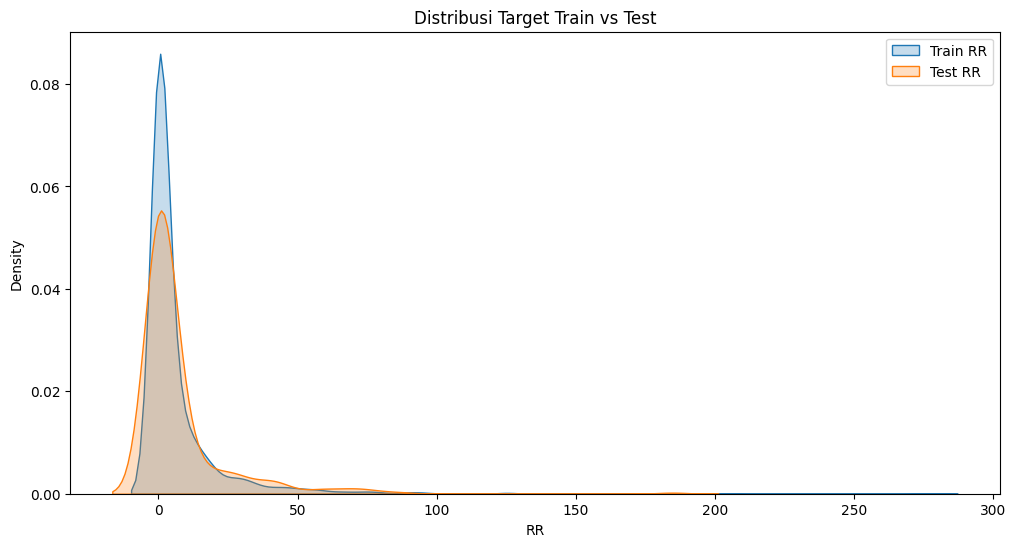

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.kdeplot(y_train, label='Train Curah Hujan (mm)', fill=True)
sns.kdeplot(y_test, label='Test Curah Hujan (mm)', fill=True)
plt.title("Distribusi Target Train vs Test")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Perbaikan: variable 'corr' dan function '.corr()'
corr = pd.concat([X_train, y_train], axis=1).corr()

# Perbaikan: variable 'target_corr'
target_corr = corr['Curah Hujan (mm)'].sort_values(ascending=False)

print("Korelasi Fitur dengan Target:")
print(target_corr)

Korelasi Fitur dengan Target:
RR               1.000000
RR_diff1         0.630054
RR_7d            0.488228
RH_AVG           0.397900
RR_14d           0.392493
RR_30d           0.343710
Rain_7d_count    0.273764
RR_lag1          0.205826
month_sin        0.194030
RR_lag2          0.144035
month_cos        0.132766
DDD_X            0.103375
RR_lag7          0.100568
RR_lag3          0.099001
RH_diff1         0.044484
DDD_CAR          0.012741
FF_X             0.011858
FF_AVG           0.001426
day_cos         -0.000207
day_sin         -0.011507
temp_range      -0.059098
SS              -0.195308
TAVG_lag1       -0.311649
TX              -0.321259
TAVG            -0.389429
TN              -0.392595
Name: RR, dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred_train_rf = rf.predict(X_train_scaled)
pred_test_rf = rf.predict(X_test_scaled)

# Perbaikan fungsi mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train, pred_train_rf))
test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test_rf))

# Perbaikan fungsi mean_absolute_error
train_mae = mean_absolute_error(y_train, pred_train_rf)
test_mae  = mean_absolute_error(y_test, pred_test_rf)

print("RF Train RMSE:", train_rmse)
print("RF Test RMSE :", test_rmse)
print("RF Train MAE:", train_mae)
print("RF Test MAE :", test_mae)

RF Train RMSE: 1.7571655046763552
RF Test RMSE : 2.3704041811425376
RF Train MAE: 0.333738546871672
RF Test MAE : 0.8248523144750799


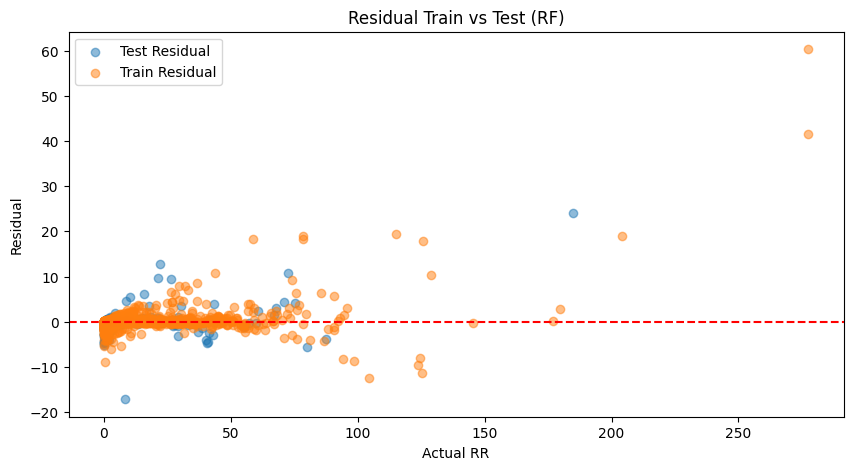

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test - pred_test_rf, alpha=0.5, label="Test Residual")
plt.scatter(y_train, y_train - pred_train_rf, alpha=0.5, label="Train Residual")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Curah Hujan (mm)")
plt.ylabel("Residual")
plt.legend()
plt.title("Residual Train vs Test (RF)")
plt.show()


# Predict Future (Forecast)

In [ ]:
def build_future_features(history_df, future_date):
    history_df = history_df.copy()
    future_date = pd.to_datetime(future_date)

    last_30 = history_df.tail(30)

    base = history_df.iloc[-1].copy()
    base['Tanggal'] = future_date

    # Date features
    base['month'] = future_date.month
    base['day']   = future_date.day

    base['month_sin'] = np.sin(2*np.pi*base['month']/12)
    base['month_cos'] = np.cos(2*np.pi*base['month']/12)
    base['day_sin']   = np.sin(2*np.pi*base['day']/31)
    base['day_cos']   = np.cos(2*np.pi*base['day']/31)

    base['temp_range'] = base['Temperatur Maksimum'] - base['TN']

    # def season(m):
    #     return 1 if m in [12,1,2] else 2 if m in [3,4,5] else 3 if m in [6,7,8] else 4
    # base['season'] = season(base['month'])

    temp = pd.concat([last_30, pd.DataFrame([base])], ignore_index=True)

    temp['Curah Hujan (mm)_lag1'] = temp['Curah Hujan (mm)'].shift(1)
    temp['Curah Hujan (mm)_lag2'] = temp['Curah Hujan (mm)'].shift(2)
    temp['Curah Hujan (mm)_lag3'] = temp['Curah Hujan (mm)'].shift(3)
    temp['Curah Hujan (mm)_lag7'] = temp['Curah Hujan (mm)'].shift(7)
    temp['Temperatur Rata-rata_lag1'] = temp['Temperatur Rata-rata'].shift(1)

    temp['Curah Hujan (mm)_diff1'] = temp['Curah Hujan (mm)'] - temp['Curah Hujan (mm)_lag1']
    temp['RH_diff1'] = temp['Kelembapan Rata-rata'] - temp['Kelembapan Rata-rata'].shift(1)

    temp['Curah Hujan (mm)_7d']  = temp['Curah Hujan (mm)'].rolling(7).mean()
    temp['Curah Hujan (mm)_14d'] = temp['Curah Hujan (mm)'].rolling(14).mean()
    temp['Curah Hujan (mm)_30d'] = temp['Curah Hujan (mm)'].rolling(30).mean()

    temp['Rain_7d_count'] = temp['Curah Hujan (mm)'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    return temp.iloc[-1:]


In [ ]:
def forecast_7_days(
    df,
    start_date,
    features,
    scaler,
    rf,
    xgb,
    lstm_model
):
    history = df.copy()
    results = []

    # Perbaikan: variable 'current_date'
    current_date = pd.to_datetime(start_date)

    for i in range(7):
        # Perbaikan: variable 'current_date'
        next_date = current_date + pd.Timedelta(days=1)

        # Pastikan fungsi build_future_features sudah didefinisikan sebelumnya
        future_row = build_future_features(history, next_date) 
        future_scaled = scaler.transform(future_row[features])

        # Predictions
        pred_rf  = rf.predict(future_scaled)[0]
        pred_xgb = xgb.predict(future_scaled)[0]
        pred_lstm = lstm_model.predict(
            future_scaled.reshape(1,1,-1)
        )[0][0]

        # Ensemble simple (Rata-rata)
        pred_mean = np.mean([pred_rf, pred_xgb, pred_lstm])

        results.append({
            "Tanggal": next_date,
            "RF": pred_rf,
            "XGB": pred_xgb,
            "LSTM": pred_lstm,
            "Ensemble": pred_mean
        })

        # Append prediction untuk dipakai prediksi hari berikutnya (Recursive)
        new_row = future_row.copy()
        
        # Bagian ini TETAP, karena ini nama kolom di Dataframe
        new_row['Curah Hujan (mm)'] = pred_mean   
        
        history = pd.concat([history, new_row], ignore_index=True)

        # Perbaikan: variable 'current_date'
        current_date = next_date

    return pd.DataFrame(results)

In [ ]:
future_7d = forecast_7_days(
    df=df,
    start_date="2025-12-01",
    features=features,
    scaler=scaler,
    rf=rf,
    xgb=xgb,
    lstm_model=model
)

print(future_7d)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
     Tanggal            RF       XGB      LSTM  Ensemble
0 2025-12-02  6.550262e-01  0.472585  0.090677  0.406096
1 2025-12-03  2.178406e-01  0.159403  0.049519  0.142254
2 2025-12-04  8.964781e-08  0.000580 -0.006036 -0.001819
3 2025-12-05  8.964781e-08  0.003584 -0.022989 -0.006468
4 2025-12-06  8.964781e-08  0.004428 -0.036096 -0.010556
5 2025-12-07  8.964781e-08  0.004679 -0.025008 -0.006776
6 2025-12-08  8.964781e-08  0.001535 -0.010978 -0.003148
